/home/research2/miniconda3/envs/mlexp/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2461/2461 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


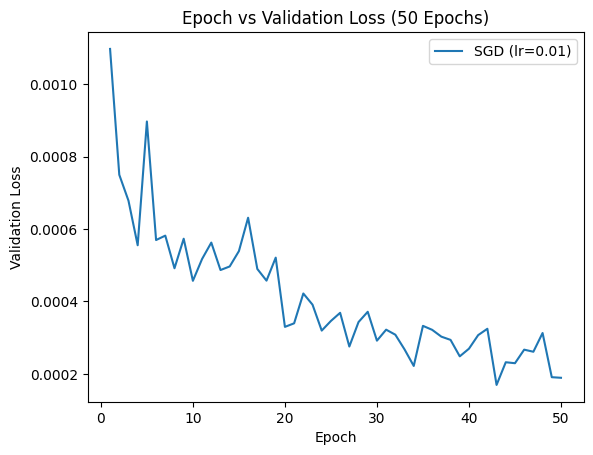

Results with optimizer [SGD] MSE: 0.0002 MAE: 0.0102 R2: 0.9965
2461/2461 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Testing time: 5.45 seconds


'# Flatten the predictions and actual values to 1D arrays for plotting\ny_test_flat = y_test.to_numpy().flatten()\ny_pred_flat = predictions.flatten()'

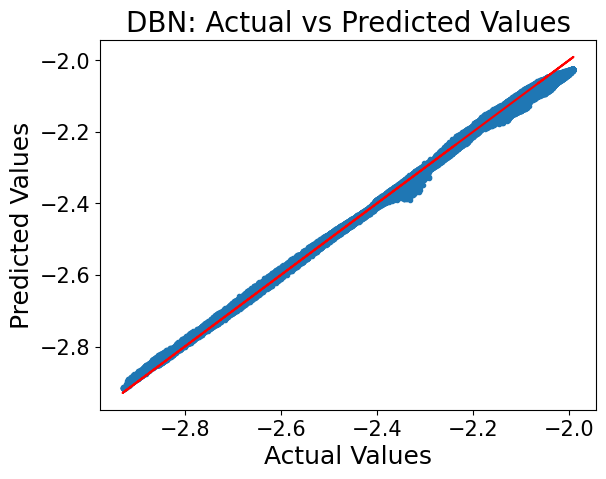

In [5]:
#Code checked: 09/23/2024, Dumi

# Import necessary libraries for data handling, model building, and evaluation
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import time

# Load dataset
df = pd.read_csv('new_vega_rotation_overshooting_alpha_mlt_test_no_num_BIGGER_num_gt_180.csv')

# Split the dataset into features (X) and target variable (y)
X = df[['mass', 'z','fov','mlt', 'age', 'teff', 'lum']]
y = df['log_k']

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Standardize the data to have zero mean and unit variance
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Function to build the Deep Belief Network (DBN) model structure
def build_dbn(input_dim):
    model = Sequential()
    model.add(Dense(256, input_dim=input_dim, activation='relu'))  # First hidden layer
    model.add(Dropout(0.2))  # Dropout for regularization
    model.add(Dense(128, activation='relu'))  # Second hidden layer
    model.add(Dropout(0.2))  # Dropout for regularization
    model.add(Dense(64, activation='relu'))  # Third hidden layer
    model.add(Dropout(0.2))  # Dropout for regularization
    model.add(Dense(1, activation='linear'))  # Output layer for regression
    return model

# Function to compile and train the DBN model
def compile_and_train_dbn(X_train, y_train, X_test, y_test, optimizer, epochs):
    model = build_dbn(X_train.shape[1])  # Build model with input dimension
    opt = tf.keras.optimizers.get({
        'class_name': optimizer['name'],
        'config': {'learning_rate': optimizer['learning_rate']}
    })  # Retrieve optimizer with specified learning rate
    model.compile(optimizer=opt, loss='mean_squared_error')  # Compile model with MSE loss
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=16, validation_split=0.2, verbose=0)  # Train model
    y_pred = model.predict(X_test)  # Predict on test data
    mse = mean_squared_error(y_test, y_pred)  # Calculate Mean Squared Error
    mae = mean_absolute_error(y_test, y_pred)  # Calculate Mean Absolute Error
    r2 = r2_score(y_test, y_pred)  # Calculate R-squared score
    return model, history.history['val_loss'], mse, mae, r2  # Return model and metrics

# Define the list of epoch amounts to try for training
epoch_amounts = [50]

# Define a list of optimizers with respective learning rates
optimizers = [
    #{'name': 'Adam', 'learning_rate': 0.001},
    {'name': 'SGD', 'learning_rate': 0.01}
    #{'name': 'Adagrad', 'learning_rate': 0.01},
    # {'name': 'RMSprop', 'learning_rate': 0.001},
    # {'name': 'Adadelta', 'learning_rate': 1.0},
    # {'name': 'Nadam', 'learning_rate': 0.002}
]

best_model = None  # Initialize variable to store the best model
best_mse = float('inf')  # Initialize the best MSE value to a high number

# Loop through each epoch amount
for epochs in epoch_amounts:
    mses = []  # List to store MSE for each optimizer
    maes = []  # List to store MAE for each optimizer
    r2s = []  # List to store R-squared values for each optimizer

    # Plot epoch vs. validation loss
    plt.figure()
    x = range(1, epochs + 1)  # X-axis values for the plot

    # Loop through each optimizer in the list
    for optimizer in optimizers:
        model, val_loss, mse, mae, r2 = compile_and_train_dbn(X_train, y_train, X_test, y_test, optimizer, epochs)
        mses.append(mse)  # Append MSE to list
        maes.append(mae)  # Append MAE to list
        r2s.append(r2)  # Append R-squared to list
        plt.plot(x, val_loss, label=f"{optimizer['name']} (lr={optimizer['learning_rate']})")  # Plot validation loss

        # Update best model if current model's MSE is lower
        if mse < best_mse:
            best_mse = mse
            best_model = model

    plt.xlabel('Epoch')
    plt.ylabel('Validation Loss')
    plt.title(f'Epoch vs Validation Loss ({epochs} Epochs)')
    plt.legend()
    plt.show()

    # Print results for each optimizer
    for j, optimizer in enumerate(optimizers):
        print(f"Results with optimizer [{optimizer['name']}] MSE: {mses[j]:.4f} MAE: {maes[j]:.4f} R2: {r2s[j]:.4f}")

# Use the best model to make predictions and visualize results
start_time = time.time()  # Record start time
predictions = best_model.predict(X_test)  # Predict on test data
end_time = time.time()  # Record end time
test_time = end_time - start_time  # Calculate prediction time
print(f"Testing time: {test_time:.2f} seconds")

# Plot actual vs. predicted values
fig, ax = plt.subplots()
ax.set_xlabel(r"Actual Values", fontsize=18)
ax.set_ylabel(r"Predicted Values", fontsize=18)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.plot(y_test, predictions, '.')  # Plot predicted vs actual values
ax.plot(y_test, y_test, color='r')  # Plot reference line for perfect predictions
ax.set_title('DBN: Actual vs Predicted Values', fontsize=20)

# # Uncomment to flatten predictions and actual values for plotting
# y_test_flat = y_test.to_numpy().flatten()
# y_pred_flat = predictions.flatten()



/tmp/ipykernel_3314663/1842435969.py:4: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_test_arr = y_test.ravel()


Text(0, 0.5, 'Frequency')

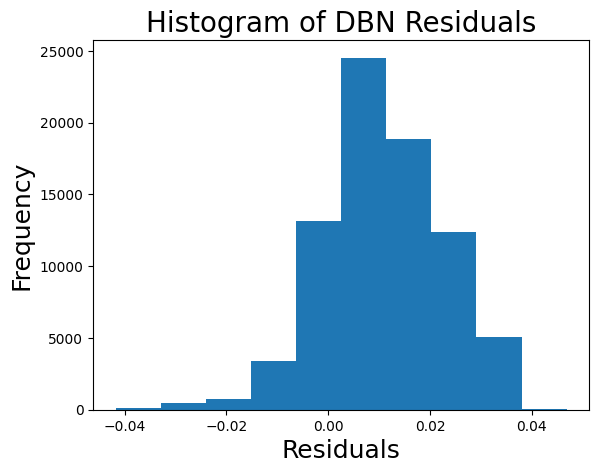

In [2]:
##### Residuals ########

# Convert y_test and predictions to 1D arrays
y_test_arr = y_test.ravel()
predictions_arr = predictions.ravel()

plt.hist(y_test_arr - predictions_arr)

# Set a fixed range for the y-axis
# plt.ylim(0, 500) 
# plt.xlim(-0.08, 0.08)

# Plot the histogram
plt.title('Histogram of DBN Residuals', fontsize=20)
plt.xlabel('Residuals', fontsize=18)
plt.ylabel('Frequency', fontsize=18)

## Feature Importance

2461/2461 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
2461/2461 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
2461/2461 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
2461/2461 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
2461/2461 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
2461/2461 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
2461/2461 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
2461/2461 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Feature 'mass': Importance Score = 0.06401923092791173
Feature 'z': Importance Score = 0.024297441406889275
Feature 'fov': Importance Score = 0.0005322810810491907
Feature 'mlt': Importance Score = 0.00015707428200550932
Feature 'age': Importance Score = 0.16282865860563722
Feature 'teff': Importance Score = 0.3033083732704135
Feature 'lum': Importance Score = 0.7162422686677743


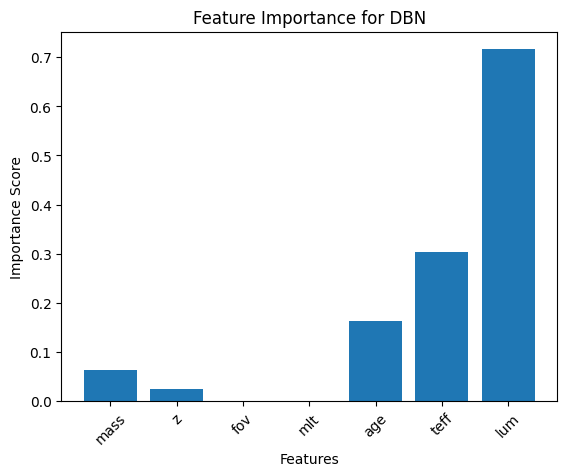

In [7]:
import matplotlib.pyplot as plt
from mlxtend.evaluate import feature_importance_permutation

feature_names = ['mass', 'z', 'fov', 'mlt', 'age', 'teff', 'lum']

# Define a prediction function
def model_predict(X):
    return model.predict(X).flatten()

# Calculate permutation feature importance
imp_vals, imp_all = feature_importance_permutation(
    predict_method=model_predict,
    X=X_test,
    y=y_test,
    metric='r2',
    num_rounds=1,
    seed=1
)

# Display the feature importance
for i, score in enumerate(imp_vals):
    print(f"Feature '{feature_names[i]}': Importance Score = {score}")
    
# Plot feature importance
plt.bar(range(len(imp_vals)), imp_vals, tick_label=feature_names)
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.title('Feature Importance for DBN')
plt.xticks(rotation=45)
plt.show()


## SHAP

In [2]:
# Install SHAP library
!pip install shap
import shap

/home/research2/miniconda3/envs/mlexp/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ExactExplainer explainer: 5001it [00:58, 72.13it/s]                                                                        


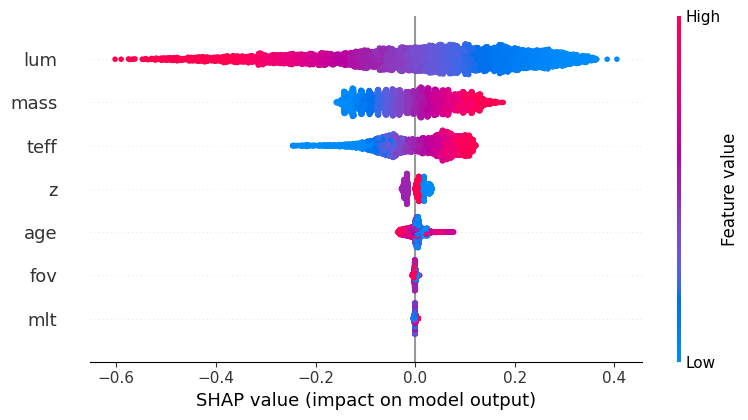

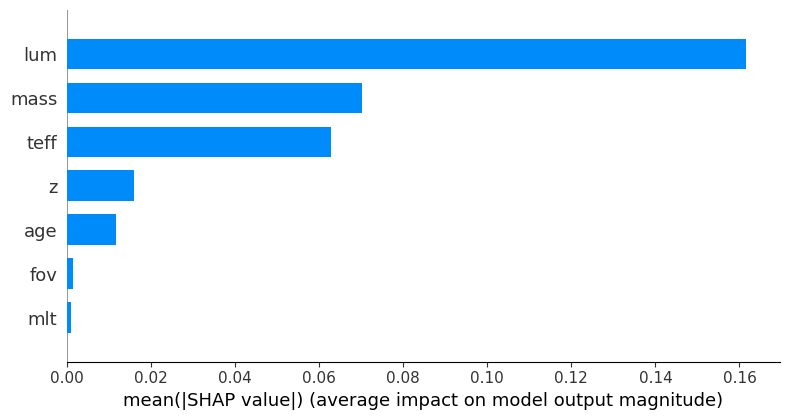

In [4]:
#===============================================================================
X_train_sample=pd.DataFrame(X_train).sample(n=5000, random_state=41).to_numpy()
X_test_sample=pd.DataFrame(X_test).sample(n=5000, random_state=45).to_numpy()
#===============================================================================

# Create a SHAP explainer
explainer = shap.Explainer(model, X_train_sample)

# Get SHAP values for a subset of the test set
shap_values = explainer(X_test_sample)

# Plot feature importance bar chart
shap.summary_plot(shap_values, X_test_sample, feature_names=['mass', 'z', 'fov', 'mlt', 'age', 'teff', 'lum'])
shap.summary_plot(shap_values, X_test_sample, feature_names=['mass', 'z', 'fov', 'mlt', 'age', 'teff', 'lum'], plot_type="bar")
